<a href="https://colab.research.google.com/github/All4Nothing/pytorch-DL-project/blob/main/Ch05_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. 하이브리드 고급 모델

## 언어 모델링을 위한 트랜스포머 모델 만들기

### 언어 모델링  
**언어 모델링**은 특정 단어 시퀸스가 주어졌을 때 그 뒤를 따를 단어 또는 단어 시퀸스의 발생 확률을 알아내는 작업이다.  
예를 들어 'French is a beautiful ___'가 단어 시퀸스로 주어지면 다음에 등장할 단어가 'language'나 'word'등이 나올 확률일 얼마일가? 이러한 확률은 다양한 확률론적/통계적 기술을 사용해 언어를 모델링함으로써 계산된다. 이는 어떤 단어들이 함께 등장하고, 어떤 단어들이 절대 함께 나오지 않는지를 배움으로써 텍스트 말뭉치를 관찰하고 문법을 학습하는 것에서 비롯됐다.  
언어 모델은 이러한 방식으로 다양한 시퀸스가 주어졌을 때 다른 단어 또는 시퀸스가 발생할 확률적 규칙을 정한다.

In [1]:
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import torchtext
from torchtext.data.utils import get_tokenizer



```
TransformerEncoder, TransformerEncoderLayer
```
는 Transformer 모델에 특화된 모듈이다.



### Transformer Model Architecture

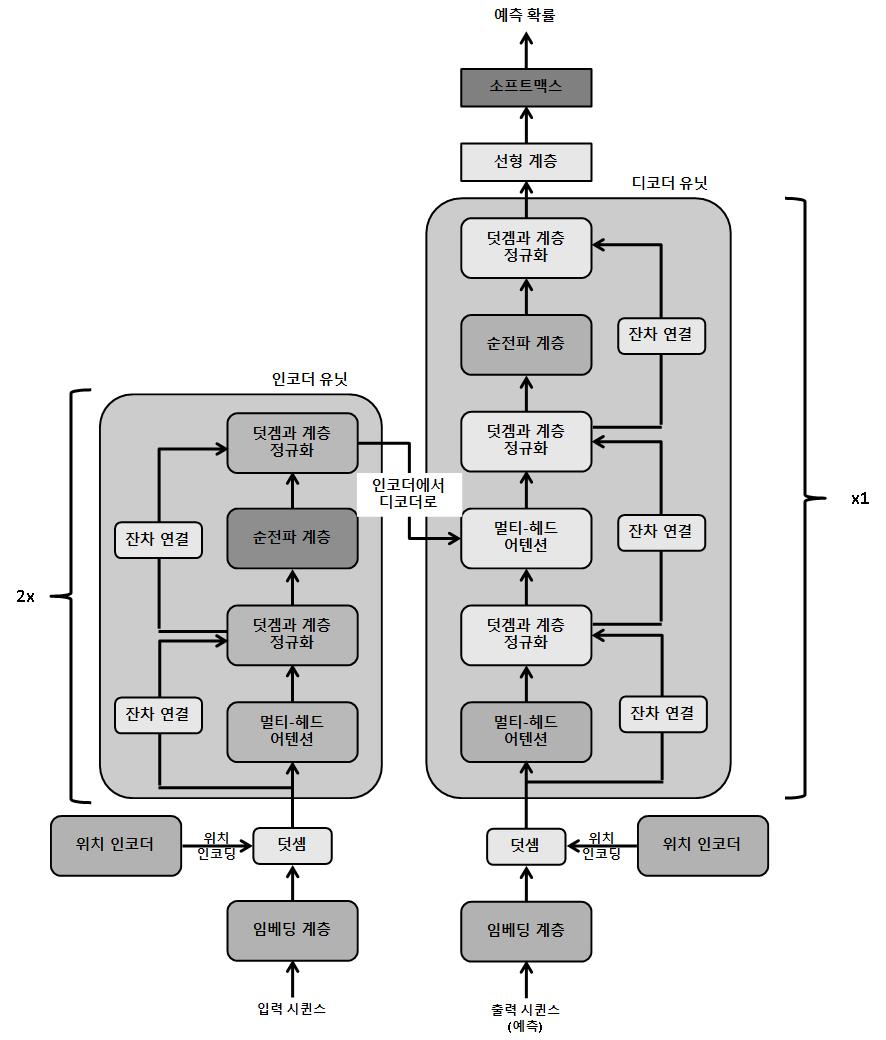    
![attention](https://velog.velcdn.com/images%2Fyjinheon%2Fpost%2F0650b1ec-c415-4137-ae48-0b1844a512c0%2FAttenstion_is_all_You_Need1.png)
Transformer 모델은 인코더-디코더 기반의 아키첵처 이다. 아키텍처가 깊어질수록 인코더와 디코더는 여러번 이어 붙일 수 있다. 이 그림에서는 2개의 인코더와 하나의 디코더로 구성되어 있다. 이 인코더-디코더 설정은 인코더가 시퀸스를 입력으로 가져와서 입력 시퀸스에 있는 단어 수만큼의 임베딩을 생성함(단어 하나 당 하나의 임베딩)을 뜻한다. 이 임베딩은 지금까지 모델에서 만들어진 예측과 함께 디코더에 제공된다.


- **임베딩 계층** : 이 계층은 임베딩, 즉 시퀸스의 각 입력 단어를 숫자 벡터로 변환하는 전형적인 작업을 수행한다. `torch.nn.Embedding` 모듈을 사용한다.  
- **위치 인코더** : transformer 모델은 아키텍처에 순환 계층이 없지만, 시퀸스 작업에서 순환 네트워크보다 성능이 뛰어나다. 위치 인코딩(positional encoding)이라는 깔끔한 트릭으로 모델이 데이터의 순서에 대해 감을 잡을 수 있기 때문이다. 특정 순차 패턴을 따르는 벡터가 입력 단어 임베딩에 추가된다. 이러한 벡터는 모델에서 첫 번째 단어 뒤에 두번째 단어가 따라 나오는 것을 이해할 수 있게 하는 방식으로 생성된다. 벡터는 후속 단어 사이의 규칙적인 주기성과 거리를 나타내기 위해 각각 사인 곡선(sinusoidal) 함수와 코사인 곡선(cosinusoidal) 함수를 사용해 생성된다.  
sin과 cos 함수는 순차 패턴을 제공하기 위해 번갈아 사용된다.

In [2]:
class PosEnc(nn.Module):
    def __init__(self, d_m, dropout=0.2, size_limit=5000):
        # d_m is same as the dimension of the embeddings
        super(PosEnc, self).__init__()
        self.dropout = nn.Dropout(dropout)
        p_enc = torch.zeros(size_limit, d_m)
        pos = torch.arange(0, size_limit, dtype=torch.float).unsqueeze(1)
        divider = torch.exp(torch.arange(0, d_m, 2).float() * (-math.log(10000.0) / d_m))
        # divider is the list of radians, multiplied by position indices of words, and fed to the sinusoidal and cosinusoidal function
        p_enc[:, 0::2] = torch.sin(pos * divider) # 0, 2, 4 ...
        p_enc[:, 1::2] = torch.cos(pos * divider) # 1, 3, 5 ...
        p_enc = p_enc.unsqueeze(0).transpose(0, 1)
        self.register_buffer('p_enc', p_enc)

    def forward(self, x):
        return self.dropout(x + self.p_enc[:x.size(0), :])

*self-attention layer* : self-attention layer는 attention 메커니즘이 자기 자신, 즉 시퀸스의 각 단어에 적용된다. 시퀸스의 각 단어 임베딩은 셀프-어텐션 계층을 통과해 단어 임베딩과 똑같은 길이의 개별 출력을 만들어 낸다.  
각 단어에 대해 세 개의 벡터가 세 개의 학습 가능한 매개변수 행렬(Pq(query), Pk(key), Pv(value))를 통해 생성된다. query와 key 벡터를 스칼라곱(또는 점곱)하여 각 단어에 대한 숫자를 생성한다. 이 숫자를 각 단어의 키 벡터 길이의 제곱근으로 나누어 정규화한다. 모든 단어에 대해 결과 숫자에 소프트맥스 함수가 동시에 적용되어 확률을 생성하고, 이 확률에 마지막으로 각 단어의 value 벡터를 곱한다.  
결과적으로 시퀸스의 각 단어에 대한 하나의 출력 벡터가 생성되는데 이때 출력 벡터의 길이는 입력 단어 임베딩과 동일하다.
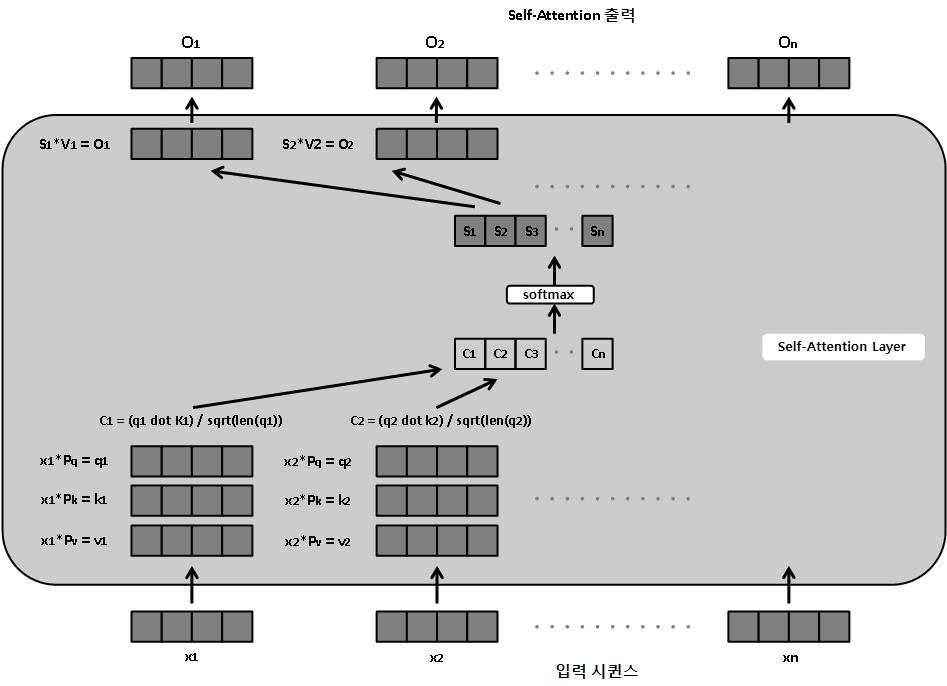  

- **멀티-헤드 어텐션** : 멀티-헤드 어텐션 계층은 여러 셀프-어텐션 모듈이 각 단어에 대한 출력을 계산하는 셀프-어텐션 계층의 확장판이다. 이 개별 출력을 연결하고 다른 매개변수 행렬(Pm)과 행렬 곱해서 입력 임베딩 벡터와 길이가 같은 최종 출력 벡터를 생성한다.  
셀프-어텐션 헤드를 여러 개 두면 여러 개의 헤드가 시퀸스 단어의 다양한 관점에 집중하도록 도와준다. 이는 합성곱 신경망에서 여러 개의 특징 맵이 다양한 패턴을 학습하는 방법과 유사하다.  
또한 디코더 유닛의 마스킹된 멀티-헤드 어텐션 계층은 마스킹이 추가됐다는 점을 제외하면 멀티-헤드 어텐션 계층과 똑같은 방식으로 작동한다. 즉, 시퀸스 처리의 시간 단계 t가 주어지면 t+1에서 n(시퀸스 길이)까지의 모든 단어가 마스킹(숨겨짐)된다.  
훈련하는 동안 디코더에는 두 종류의 입력이 제공된다. 그중 하나는 최종 인코더에서 query와 key 벡터를 입력으로 받아 마스킹되지 않은 멀티-헤드 어텐션 계층으로 전달한다. 여기에서 이 query와 key 벡터는 최종 인코더 출력을 행렬로 변환한 것이다. 다른 하나는 이전 시간 단계에서 만들어진 예측을 입력으로 받아 마스킹된 멀티-헤드 어텐션 계층에 전달한다.
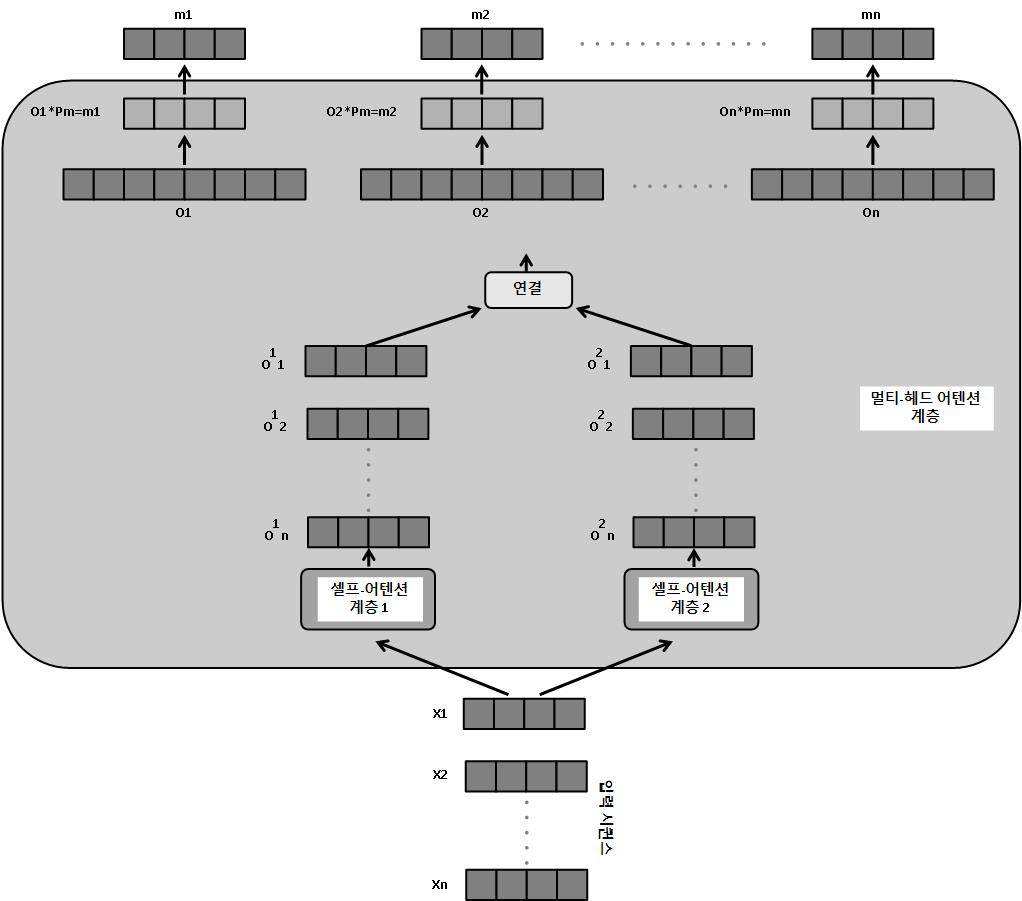


- **덧셈과 계층 정규화(Addition & Layer Normalization)** : Transformer 모델 아키텍처에서 Add & Norm 계층들 간에 Residual Connection이 있는 것을 볼 수 있다. 각 인스턴스에서 입력 단어 임베딩 벡터를 멀티-헤드 어텐션 계층의 출력 벡터에 바로 더함으로써 Residual Connection이 설정된다. 이렇게 하면 네트워크 전체에서 경사를 전달하기 더 쉽고 경사가 폭발하거나 소실하는 문제를 피할 수 있다. 또한 계층 간에 항등 함수를 효율적으로 학습하는데 도움이 된다.  
게다가 계층 정규화는 정규화 기법으로 사용된다. 여기에서 각 특징이 독립적으로 정규화되어 모든 특징이 균등한 평균과 표준편차를 갖는다. 이러한 Add & Norm은 네트워크의 각 단계에서 시퀸스의 각 단어 벡터에 개별적으로 적용된다.

- **순전파 계층(Forward)** : 인코더와 디코더 유닛 모두에서 시퀸스의 모든 단어에 대해 정규화된 residual 출력 벡터가 공통 forward 계층을 통해 전달된다. 단어 전체에 공통 매개변수 세트가 있기 때문에 이 계층은 시퀸스 전체에서 더 광범위한 패턴을 학습하는 데 도움이 된다.

- **선형 및 소프트맥스 계층(Linear & Softmax)** : 지금까지 각 계층은 단어당 하나씩 벡터 시퀸스를 출력한다. Linear 계층은 벡터 시퀸스를 단어 사전의 길이와 똑같은 크기를 갖는 단일 벡터로 변환한다. 소프트맥스 계층은 이 출력을 확률 벡터(확률 벡터의 총합은 1)로 변환한다. 이 확률은 사전에서 각 단어가 시퀸스의 단어로 등장할 확률을 의미한다.

### Define Transformer Model with PyTorch

In [3]:
class Transformer(nn.Module):
    def __init__(self, num_token, num_inputs, num_heads, num_hidden, num_layers, dropout=0.3):
        super(Transformer, self).__init__()
        self.model_name = 'transformer'
        self.mask_source = None
        self.position_enc = PosEnc(num_inputs, dropout)
        layers_enc = TransformerEncoderLayer(num_inputs, num_heads, num_hidden, dropout)
        self.enc_transformer = TransformerEncoder(layers_enc, num_layers)
        self.enc = nn.Embedding(num_token, num_inputs)
        self.num_inputs = num_inputs
        self.dec = nn.Linear(num_inputs, num_token)
        self.init_params()

    def _gen_sqr_nxt_mask(self, size):
        msk = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        msk = msk.float().masked_fill(msk == 0, float('-inf'))
        msk = msk.masked_fill(msk == 1, float(0.0))
        return msk

    def init_params(self):
        initial_rng = 0.12
        self.enc.weight.data.uniform_(-initial_rng, initial_rng)
        self.dec.bias.data.zero_()
        self.dec.weight.data.uniform_(-initial_rng, initial_rng)

    def forward(self, source):
        if self.mask_source is None or self.mask_source.size(0) != len(source):
            dvc = source.device
            msk = self._gen_sqr_nxt_mask(len(source)).to(dvc)
            self.mask_source = msk

        source = self.enc(source) * math.sqrt(self.num_inputs)
        source = self.position_enc(source)
        op = self.enc_transformer(source, self.mask_source)
        op = self.dec(op)
        return op

언어 모델링 작업의 경우 단어 시퀸스를 입력으로 받아 단일 출력만 내면 된다. 이 때문에 디코더(`self.dec`)는 인코더의 벡터 시퀸스를 단일 출력 벡터로 변환하는 선형 계층일 뿐이다.

### Load Dataset  
[위키피디아 텍스트 사용](https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/)

In [6]:
!pip install torchtext==0.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [4]:
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"), lower=True, eos_token='<eos>', init_token='<sos>')
training_text, validation_text, testing_text = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(training_text)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_batches(text_dataset, batch_size):
    text_dataset = TEXT.numericalize([text_dataset.examples[0].text])
    # divide text dataset into parts of size equal to batch_size
    num_batches = text_dataset.size(0) // batch_size
    # remove data points that lie outside batches (remainders)
    text_dataset = text_dataset.narrow(0, 0, num_batches * batch_size)
    # distribute dataset across batches evenly
    text_dataset = text_dataset.view(batch_size, -1).t().contiguous()
    return text_dataset.to(device)

training_batch_size = 32
evaluation_batch_size = 16

training_data = gen_batches(training_text, training_batch_size)
validation_data = gen_batches(validation_text, evaluation_batch_size)
testing_data = gen_batches(testing_text, evaluation_batch_size)

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 10.2MB/s]


extracting


In [5]:
max_seq_len = 64
def return_batch(src, k):
    sequence_length = min(max_seq_len, len(src) - 1 - k)
    sequence_data = src[k:k+sequence_length]
    sequence_label = src[k+1:k+1+sequence_length].view(-1)
    return sequence_data, sequence_label

### Train Transformer Model

In [6]:
num_tokens = len(TEXT.vocab.stoi) # vocabulary size
embedding_size = 256 # dimension of embedding layer
num_hidden_params = 256 # transformer encoder's hidden (feed forward) layer dimension
num_layers = 2 # num of transformer encoder layers within transformer encoder
num_heads = 2 # num of heads in (multi head) attention models
dropout = 0.25 # value (fraction) of dropout
loss_func = nn.CrossEntropyLoss()
lrate = 4.0 # learning rate
transformer_model = Transformer(num_tokens, embedding_size, num_heads, num_hidden_params, num_layers,
                                     dropout).to(device)
optim_module = torch.optim.SGD(transformer_model.parameters(), lr=lrate)
sched_module = torch.optim.lr_scheduler.StepLR(optim_module, 1.0, gamma=0.88)

In [7]:
def train_model():
    transformer_model.train()
    loss_total = 0.
    time_start = time.time()
    num_tokens = len(TEXT.vocab.stoi)
    for b, i in enumerate(range(0, training_data.size(0) - 1, max_seq_len)):
        train_data_batch, train_label_batch = return_batch(training_data, i)
        optim_module.zero_grad()
        op = transformer_model(train_data_batch)
        loss_curr = loss_func(op.view(-1, num_tokens), train_label_batch)
        loss_curr.backward()
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), 0.6)
        optim_module.step()

        loss_total += loss_curr.item()
        interval = 100
        if b % interval == 0 and b > 0:
            loss_interval = loss_total / interval
            time_delta = time.time() - time_start
            print(f"epoch {ep}, {b}/{len(training_data)//max_seq_len} batches, training loss {loss_interval:.2f}, training perplexity {math.exp(loss_interval):.2f}")
            loss_total = 0
            time_start = time.time()

def eval_model(eval_model_obj, eval_data_source):
    eval_model_obj.eval()
    loss_total = 0.
    num_tokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for j in range(0, eval_data_source.size(0) - 1, max_seq_len):
            eval_data, eval_label = return_batch(eval_data_source, j)
            op = eval_model_obj(eval_data)
            op_flat = op.view(-1, num_tokens)
            loss_total += len(eval_data) * loss_func(op_flat, eval_label).item()
    return loss_total / (len(eval_data_source) - 1)

In [8]:
min_validation_loss = float("inf")
eps = 5
best_model_so_far = None

for ep in range(1, eps + 1):
    ep_time_start = time.time()
    train_model()
    validation_loss = eval_model(transformer_model, validation_data)
    print()
    print(f"epoch {ep:}, validation loss {validation_loss:.2f}, validation perplexity {math.exp(validation_loss):.2f}")
    print()

    if validation_loss < min_validation_loss:
        min_validation_loss = validation_loss
        best_model_so_far = transformer_model

    sched_module.step()

epoch 1, 100/1018 batches, training loss 8.60, training perplexity 5436.95
epoch 1, 200/1018 batches, training loss 7.28, training perplexity 1449.65
epoch 1, 300/1018 batches, training loss 6.82, training perplexity 918.97
epoch 1, 400/1018 batches, training loss 6.61, training perplexity 741.83
epoch 1, 500/1018 batches, training loss 6.50, training perplexity 663.86
epoch 1, 600/1018 batches, training loss 6.33, training perplexity 561.84
epoch 1, 700/1018 batches, training loss 6.28, training perplexity 532.29
epoch 1, 800/1018 batches, training loss 6.15, training perplexity 467.29
epoch 1, 900/1018 batches, training loss 6.12, training perplexity 453.94
epoch 1, 1000/1018 batches, training loss 6.09, training perplexity 441.00

epoch 1, validation loss 5.80, validation perplexity 330.38

epoch 2, 100/1018 batches, training loss 6.00, training perplexity 405.02
epoch 2, 200/1018 batches, training loss 5.93, training perplexity 374.84
epoch 2, 300/1018 batches, training loss 5.84, 

* 혼란도(perplexity) : 혼란도는 자연어 처리에서 확률 분포(여기서는 언어 모델)가 샘플에 얼마나 잘 맞느지 또는 잘 예측하는지를 나타내기 위해 사용되는 평가 지표다. 수학적으로 혼란도는 교차-엔트로피 손실의 지수다. 직관적으로 이 평가 지표는 모델이 예측할 때 얼마나 혼란스러운지를 나타낼 때 사용된다.

In [9]:
testing_loss = eval_model(best_model_so_far, testing_data)
print(f"testing loss {testing_loss:.2f}, testing perplexity {math.exp(testing_loss):.2f}")

testing loss 5.15, testing perplexity 171.74


2017년에 고안된 초기 트랜스포머 모델 외에 수년에 걸쳐 특히 언어 모델링 분야에서 여러 후속 모델들이 개발됐다.  
- Bidirectional Encoder Representations from Transformers (BERT), 2018  
- Generative Pretrained Transformer (GPT), 2018  
- GPT-2, 2019  
- Conditional Transformer Language Model (CTRL), 2019  
- Transformer-XL, 2019  
- Distilled BERT (DistilBERT), 2019  
- Robustly optimized BERT pretraining Approach (RoBERTa), 2019  
- GPT-3, 2020

HuggingFace가 개발한 transformer 라이브러리를 사용하면 이 모델들을 쉽게 사용할 수 있다.  
모델뿐 아니라 각 모델에 대한 토큰화 모델도 제공한다. 예를 들어, 언어 모델링을 위해 사전 훈련된 BERT 모델을 사용하고 싶다면 다음과 같이 사용할 수 있다.  
https://github.com/huggingface/transformers

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.7 MB/s eta 0:00:00


In [2]:
import torch
from transformers import BertForMaskedLM, BertTokenizer

bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
token_gen = BertTokenizer.from_pretrained('bert-base-uncased')


ip_sequence = token_gen("I love PyTorch !", return_tensors="pt")["input_ids"]

op = bert_model(ip_sequence, labels=ip_sequence)
total_loss, raw_preds = op[:2]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
